# Data preprocessing

In [ ]:
import json

# Mount Google Drive to access data
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/data_cged/training_data.jsonl'

# Load the data and create pairs directly
def load_data_and_create_pairs(file_path):
    sentence_pairs = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            item = json.loads(line.strip())
            # Check if both correct and error fields are present and not empty
            if item.get("correct") and item.get("error"):
                correct_item = {"sentence": item["correct"]}
                ungrammatical_item = {"sentence": item["text"]}
                sentence_pairs.append((correct_item, ungrammatical_item))

    return sentence_pairs

sentence_pairs = load_data_and_create_pairs(file_path)

print(f"Created {len(sentence_pairs)} sentence pairs from original data.")
print(sentence_pairs[1], sentence_pairs[5], sentence_pairs[10])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Created 41490 sentence pairs from original data.
({'sentence': '那下次见吧。', 'label': 1}, {'sentence': '那下次见面吧。', 'label': -1}) ({'sentence': '虽然我不能去但是他们都去。', 'label': 1}, {'sentence': '虽然我不能去但是别人他们都去。', 'label': -1}) ({'sentence': '他们都有很好的一天。', 'label': 1}, {'sentence': '他们都有很好的天。', 'label': -1})


In [ ]:
# 80-10-10 split
from sklearn.model_selection import train_test_split

train_pairs, temp_pairs = train_test_split(sentence_pairs, test_size=0.2, random_state=42)
val_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.5, random_state=42)

print(f"Number of pairs in training set: {len(train_pairs)}")
print(f"Number of pairs in validation set: {len(val_pairs)}")
print(f"Number of pairs in test set: {len(test_pairs)}")

# Inspect a few pairs from each set
print("\nExamples from training set:")
print(train_pairs[:2])

print("\nExamples from validation set:")
print(val_pairs[:2])

print("\nExamples from test set:")
print(test_pairs[:2])

Number of pairs in training set: 33192
Number of pairs in validation set: 4149
Number of pairs in test set: 4149

Examples from training set:
[({'sentence': '吸烟包括吸烟者自己对吸烟者旁边的人有影响，比如说：癌症、记忆力衰弱等等。', 'label': 1}, {'sentence': '吸烟包括吸烟者自己对吸烟者旁边的人起影响，比如说：发癌症、记忆力衰弱等等。', 'label': -1}), ({'sentence': '包括我家、大城市里的一般的家庭开冰箱满是吃的东西。看马路的垃圾堆，有很多吃不下的东西。', 'label': 1}, {'sentence': '包括我家、大城市里的一般的家庭开冰箱满着吃的东西。看马路的拉圾所，有很多吃不下的东西。', 'label': -1})]

Examples from validation set:
[({'sentence': '请你帮我买一个电脑。', 'label': 1}, {'sentence': '请你对我买一个电脑。', 'label': -1}), ({'sentence': '他毕业于上海交通大学，今年二十三岁。他以前是记者，现在没有工作。', 'label': 1}, {'sentence': '他已经毕业于上海交通大学，他今年二十三岁。他以前是记者，现在是没有工作。', 'label': -1})]

Examples from test set:
[({'sentence': '可是我有一件重要的事情，不能参加了。对不起。让你难过了。', 'label': 1}, {'sentence': '可是我有一个重要的事情，不能参加。对不起。让你难过。', 'label': -1}), ({'sentence': '“安乐死”是一种生命的选择，现在对很多病人来说可能“生”比“死”还要苦：不能吃东西，总是吃药，不能去外面，一直在病房，有的病人不会说话。如果自己的亲朋好友是这个样子的话，我绝对受不了；可能钱的负担也不小；但是这不仅是钱的问题而且是心理上的问题。', 'label': 1}, {'sentence': '“安乐死”是一种生命的选择，现在

In [ ]:
# Group pairs by new length bins based on the correct sentence length (0-9, ..., 100-109, 110+)
new_length_bins = list(range(0, 111, 10)) + [float('inf')]
new_length_labels = [f'{new_length_bins[i]}-{new_length_bins[i+1]-1}' for i in range(len(new_length_bins)-2)] + [f'{new_length_bins[-2]}+']

from collections import defaultdict
new_grouped_pairs = defaultdict(list)

for correct_item, ungrammatical_item in test_pairs:
    correct_len = len(correct_item["sentence"])

    # Find the correct bin for the correct sentence length
    assigned_bin = None
    for j in range(len(new_length_bins) - 1):
        if new_length_bins[j] <= correct_len < new_length_bins[j+1]:
            assigned_bin = new_length_labels[j]
            break
    # Handle the case for the last bin (>= 110)
    if assigned_bin is None and correct_len >= new_length_bins[-2]:
         if len(new_length_labels) > 0:
             assigned_bin = new_length_labels[-1]


    if assigned_bin:
        # Append the original pair to the correct length bin
        new_grouped_pairs[assigned_bin].append((correct_item, ungrammatical_item))

# Print the number of pairs in each new length bin
print("\nNumber of pairs in each new length bin (based on correct sentence length):")
# Sort by label
def sort_key(label):
    if '-' in label:
        try:
            return int(label.split('-')[0])
        except ValueError:
            pass
    elif '+' in label:
         try:
             return int(label.split('+')[0])
         except ValueError:
              pass
    return label

for label, pairs in sorted(new_grouped_pairs.items(), key=lambda item: sort_key(item[0])):
    print(f"Length bin '{label}': {len(pairs)} pairs")


Number of pairs in each new length bin (based on correct sentence length):
Length bin '0-9': 308 pairs
Length bin '10-19': 1091 pairs
Length bin '20-29': 657 pairs
Length bin '30-39': 560 pairs
Length bin '40-49': 481 pairs
Length bin '50-59': 341 pairs
Length bin '60-69': 248 pairs
Length bin '70-79': 176 pairs
Length bin '80-89': 114 pairs
Length bin '90-99': 59 pairs
Length bin '100-109': 42 pairs
Length bin '110+': 72 pairs


# Implementing the Dataset class

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class GrammarCheckDataset(Dataset):
    # Modified to accept a list of sentence pairs and return tokenized pairs with labels
    def __init__(self, data_pairs, tokenizer, max_length=256):
        self.data_pairs = data_pairs # This will be a list of (correct_item, ungrammatical_item) tuples
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        correct_item, ungrammatical_item = self.data_pairs[idx]

        correct_sentence = correct_item["sentence"]
        ungrammatical_sentence = ungrammatical_item["sentence"]

        # Tokenize the correct sentence
        tokenized_correct = self.tokenizer(correct_sentence,
                                          padding='max_length',
                                          truncation=True,
                                          max_length=self.max_length,
                                          return_tensors='pt')

        # Tokenize the ungrammatical sentence
        tokenized_ungrammatical = self.tokenizer(ungrammatical_sentence,
                                               padding='max_length',
                                               truncation=True,
                                               max_length=self.max_length,
                                               return_tensors='pt')

        # Return a dictionary containing tokenized correct and ungrammatical sentences and their labels
        return {
            "correct_input_ids": tokenized_correct['input_ids'].squeeze(0),
            "correct_attention_mask": tokenized_correct['attention_mask'].squeeze(0),
            "ungrammatical_input_ids": tokenized_ungrammatical['input_ids'].squeeze(0),
            "ungrammatical_attention_mask": tokenized_ungrammatical['attention_mask'].squeeze(0),
        }

# Loading the model

In [ ]:
# Check whether a GPU is available
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print(f"Using {device} device")

Using cuda device


In [ ]:
!pip install --upgrade transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "Qwen/Qwen3-0.6B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Training the model

## Dataloader

In [ ]:
batch_size = 8 # Ensure batch size is even for paired data
if batch_size % 2 != 0:
    print(f"Warning: Batch size {batch_size} is odd. Adjusting to {batch_size - 1} for paired data.")
    batch_size = batch_size - 1
elif batch_size == 0:
     print(f"Warning: Batch size cannot be 0. Adjusting to 2 for paired data.")
     batch_size = 2


# Create the datasets using the original pairs
train_dataset = GrammarCheckDataset(train_pairs, tokenizer)
validation_dataset = GrammarCheckDataset(val_pairs, tokenizer) # Use val_pairs directly
test_dataset = GrammarCheckDataset(test_pairs, tokenizer) # Use test_pairs directly

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Inspect one batch
print("Inspecting one batch from train_dataloader:")
for batch in train_dataloader:
    print("Correct input_ids shape:", batch["correct_input_ids"].shape)
    print("Correct attention_mask shape:", batch["correct_attention_mask"].shape)
    print("Ungrammatical input_ids shape:", batch["ungrammatical_input_ids"].shape)
    print("Ungrammatical attention_mask shape:", batch["ungrammatical_attention_mask"].shape)
    break

Inspecting one batch from train_dataloader:
Correct input_ids shape: torch.Size([8, 256])
Correct attention_mask shape: torch.Size([8, 256])
Ungrammatical input_ids shape: torch.Size([8, 256])
Ungrammatical attention_mask shape: torch.Size([8, 256])


## Margin Loss

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MarginLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, correct_logits, correct_attention_mask, correct_input_ids,
                ungrammatical_logits, ungrammatical_attention_mask, ungrammatical_input_ids):

        # Calculate log probability for correct sentences
        shifted_correct_logits = correct_logits[:, :-1, :].contiguous()
        correct_target_ids = correct_input_ids[:, 1:]
        correct_target_mask = correct_attention_mask[:, 1:]
        log_probs_correct_all = torch.log_softmax(shifted_correct_logits, dim=-1)
        one_hot_correct_target_ids = F.one_hot(correct_target_ids, num_classes=log_probs_correct_all.size(-1)).float()
        selected_log_probs_correct = torch.einsum('bsv,bsv->bs', log_probs_correct_all, one_hot_correct_target_ids)
        masked_log_probs_correct = selected_log_probs_correct * correct_target_mask.float()
        # Sum log probabilities over the sequence length for each sentence
        sentence_log_probs_correct = masked_log_probs_correct.sum(dim=-1) # (batch_size,)

        # Calculate log probability for ungrammatical sentences
        shifted_ungrammatical_logits = ungrammatical_logits[:, :-1, :].contiguous()
        ungrammatical_target_ids = ungrammatical_input_ids[:, 1:]
        ungrammatical_target_mask = ungrammatical_attention_mask[:, 1:]
        log_probs_ungrammatical_all = torch.log_softmax(shifted_ungrammatical_logits, dim=-1)
        one_hot_ungrammatical_target_ids = F.one_hot(ungrammatical_target_ids, num_classes=log_probs_ungrammatical_all.size(-1)).float()
        selected_log_probs_ungrammatical = torch.einsum('bsv,bsv->bs', log_probs_ungrammatical_all, one_hot_ungrammatical_target_ids)
        masked_log_probs_ungrammatical = selected_log_probs_ungrammatical * ungrammatical_target_mask.float()
        # Sum log probabilities over the sequence length for each sentence
        sentence_log_probs_ungrammatical = masked_log_probs_ungrammatical.sum(dim=-1) # (batch_size,)

        # Calculate the margin loss
        # The loss is max(0, margin - (log_prob_correct - log_prob_ungrammatical))
        loss = torch.relu(self.margin - (sentence_log_probs_correct - sentence_log_probs_ungrammatical))

        # Calculate the mean loss over the batch
        batch_loss = torch.mean(loss)

        return batch_loss

## Model fine-tuning

### LoRA

In [ ]:
from peft import LoraConfig, get_peft_model
import torch

# Define LoRA configuration
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
)

# Get PEFT model
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

trainable params: 2,293,760 || all params: 598,343,680 || trainable%: 0.3834


### Training function

In [ ]:
import tqdm
import copy
import matplotlib.pyplot as plt # Import matplotlib

def train(model, optimizer, train_dataloader, validation_dataloader, criterion, epochs=10, patience=3):

    # Track and save the model with the best validation loss
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    # Lists to store metrics for plotting
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_train_losses = []

        # Iterate through all training batches
        for batch in tqdm.tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            # Move batch components to the device
            correct_input_ids = batch["correct_input_ids"].to(device)
            correct_attention_mask = batch["correct_attention_mask"].to(device)
            ungrammatical_input_ids = batch["ungrammatical_input_ids"].to(device)
            ungrammatical_attention_mask = batch["ungrammatical_attention_mask"].to(device)

            # Reset the optimiser
            optimizer.zero_grad()

            # Forward pass for correct sentences
            outputs_correct = model(input_ids=correct_input_ids, attention_mask=correct_attention_mask)
            correct_logits = outputs_correct.logits # (batch_size, sequence_length, vocab_size)

            # Forward pass for ungrammatical sentences
            outputs_ungrammatical = model(input_ids=ungrammatical_input_ids, attention_mask=ungrammatical_attention_mask)
            ungrammatical_logits = outputs_ungrammatical.logits # (batch_size, sequence_length, vocab_size)


            # Calculate the MarginLoss
            # Pass separate logits, attention_masks, and input_ids for correct and ungrammatical sentences
            loss = criterion(correct_logits, correct_attention_mask, correct_input_ids,
                             ungrammatical_logits, ungrammatical_attention_mask, ungrammatical_input_ids)


            # Backward pass
            loss.backward()

            optimizer.step()

            epoch_train_losses.append(loss.item())

            # Print every 100 batches
            if len(epoch_train_losses) % 100 == 0:
                current_avg_train_loss = sum(epoch_train_losses)/len(epoch_train_losses) if len(epoch_train_losses) > 0 else 0
                print(f"\nEpoch: {epoch + 1}, Batch: {len(epoch_train_losses)}, current train loss: {current_avg_train_loss:.4f}")


        # Print the loss at the end of every epoch
        # Calculate the final average train loss for the epoch
        final_avg_train_loss = sum(epoch_train_losses)/len(epoch_train_losses) if len(epoch_train_losses) > 0 else 0
        print(f"\nEpoch: {epoch + 1}, processed {len(epoch_train_losses)} batches, final average train loss: {final_avg_train_loss:.4f}")
        history['train_loss'].append(final_avg_train_loss) # Store train loss


        # Validation phase
        model.eval()
        epoch_val_losses = []
        correct_predictions = 0
        total_pairs_evaluated = 0 # Count pairs for accuracy calculation

        # Disable gradient calculation for validation
        with torch.no_grad():
            for batch in tqdm.tqdm(validation_dataloader, desc=f"Epoch {epoch+1}/{epochs} (Validation)"):
                # Move batch components to the device
                correct_input_ids = batch["correct_input_ids"].to(device)
                correct_attention_mask = batch["correct_attention_mask"].to(device)
                ungrammatical_input_ids = batch["ungrammatical_input_ids"].to(device)
                ungrammatical_attention_mask = batch["ungrammatical_attention_mask"].to(device)


                # Forward pass for correct sentences
                outputs_correct = model(input_ids=correct_input_ids, attention_mask=correct_attention_mask)
                correct_logits = outputs_correct.logits

                # Forward pass for ungrammatical sentences
                outputs_ungrammatical = model(input_ids=ungrammatical_input_ids, attention_mask=ungrammatical_attention_mask)
                ungrammatical_logits = outputs_ungrammatical.logits


                # Calculate validation loss using the custom criterion
                val_loss = criterion(correct_logits, correct_attention_mask, correct_input_ids,
                                      ungrammatical_logits, ungrammatical_attention_mask, ungrammatical_input_ids)
                epoch_val_losses.append(val_loss.item())

                # Calculate Accuracy
                # Recalculate sentence log probabilities based on the logits

                # For correct sentences
                shifted_correct_logits = correct_logits[:, :-1, :].contiguous()
                correct_target_ids = correct_input_ids[:, 1:]
                correct_target_mask = correct_attention_mask[:, 1:]
                log_probs_correct_all = torch.log_softmax(shifted_correct_logits, dim=-1)
                one_hot_correct_target_ids = F.one_hot(correct_target_ids, num_classes=log_probs_correct_all.size(-1)).float()
                selected_log_probs_correct = torch.einsum('bsv,bsv->bs', log_probs_correct_all, one_hot_correct_target_ids)
                masked_log_probs_correct = selected_log_probs_correct * correct_target_mask.float()
                sentence_log_probs_correct = masked_log_probs_correct.sum(dim=-1) # (batch_size,)


                # For ungrammatical sentences
                shifted_ungrammatical_logits = ungrammatical_logits[:, :-1, :].contiguous()
                ungrammatical_target_ids = ungrammatical_input_ids[:, 1:]
                ungrammatical_target_mask = ungrammatical_attention_mask[:, 1:]
                log_probs_ungrammatical_all = torch.log_softmax(shifted_ungrammatical_logits, dim=-1)
                one_hot_ungrammatical_target_ids = F.one_hot(ungrammatical_target_ids, num_classes=log_probs_ungrammatical_all.size(-1)).float()
                selected_log_probs_ungrammatical = torch.einsum('bsv,bsv->bs', log_probs_ungrammatical_all, one_hot_ungrammatical_target_ids)
                masked_log_probs_ungrammatical = selected_log_probs_ungrammatical * ungrammatical_target_mask.float()
                sentence_log_probs_ungrammatical = masked_log_probs_ungrammatical.sum(dim=-1) # (batch_size,)


                # Compare log probabilities within each pair
                for i in range(sentence_log_probs_correct.shape[0]):
                    if sentence_log_probs_correct[i] > sentence_log_probs_ungrammatical[i]:
                        correct_predictions += 1
                    total_pairs_evaluated += 1 # Count each pair

            avg_val_loss = sum(epoch_val_losses)/len(epoch_val_losses) if len(epoch_val_losses) > 0 else 0
            val_accuracy = (correct_predictions / total_pairs_evaluated) * 100 if total_pairs_evaluated > 0 else 0

            print(f"\nEpoch: {epoch+1}, average validation loss: {avg_val_loss:.4f}, validation accuracy: {val_accuracy:.2f}%")
            history['val_loss'].append(avg_val_loss) # Store val loss
            history['val_accuracy'].append(val_accuracy) # Store val accuracy


        # Early Stopping Check
        # Use the average validation loss for early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # Save the model state dictionary when validation loss improves
            # Move each tensor within the state dictionary to CPU
            best_model_state = {k: v.cpu() for k, v in copy.deepcopy(model.state_dict()).items()}
            print(f"Validation loss improved. Saving model state.")
        else:
            epochs_no_improve += 1
            print(f"Validation loss did not improve. Epochs with no improvement: {epochs_no_improve}/{patience}")

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Validation loss did not improve for {patience} consecutive epochs.")
            break

        # End of Epoch
        model.train()

    print("Training finished.")

    # Load the best model state after training
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Loaded model state with the best validation loss.")
    else:
        print("No model state was saved (perhaps training did not complete at least one epoch).")

    return model, history # Return the best model and training history

In [ ]:
best_model, history = train(
    model,
    optimizer,
    train_dataloader,
    validation_dataloader,
    criterion=MarginLoss(),
    epochs=10,
    patience=3
)

print("Training completed.")

Epoch 1/10:   2%|▏         | 100/4149 [01:22<55:26,  1.22it/s]


Epoch: 1, Batch: 100, current train loss: 0.8402


Epoch 1/10:   5%|▍         | 200/4149 [02:45<54:04,  1.22it/s]


Epoch: 1, Batch: 200, current train loss: 0.8861


Epoch 1/10:   7%|▋         | 300/4149 [04:07<52:45,  1.22it/s]


Epoch: 1, Batch: 300, current train loss: 0.8578


Epoch 1/10:  10%|▉         | 400/4149 [05:29<51:22,  1.22it/s]


Epoch: 1, Batch: 400, current train loss: 0.8465


Epoch 1/10:  12%|█▏        | 500/4149 [06:51<50:00,  1.22it/s]


Epoch: 1, Batch: 500, current train loss: 0.8027


Epoch 1/10:  14%|█▍        | 600/4149 [08:14<48:38,  1.22it/s]


Epoch: 1, Batch: 600, current train loss: 0.7884


Epoch 1/10:  17%|█▋        | 700/4149 [09:36<47:16,  1.22it/s]


Epoch: 1, Batch: 700, current train loss: 0.7882


Epoch 1/10:  19%|█▉        | 800/4149 [10:58<45:53,  1.22it/s]


Epoch: 1, Batch: 800, current train loss: 0.7777


Epoch 1/10:  22%|██▏       | 900/4149 [12:20<44:32,  1.22it/s]


Epoch: 1, Batch: 900, current train loss: 0.7714


Epoch 1/10:  24%|██▍       | 1000/4149 [13:43<43:09,  1.22it/s]


Epoch: 1, Batch: 1000, current train loss: 0.7603


Epoch 1/10:  27%|██▋       | 1100/4149 [15:05<41:47,  1.22it/s]


Epoch: 1, Batch: 1100, current train loss: 0.7538


Epoch 1/10:  29%|██▉       | 1200/4149 [16:27<40:24,  1.22it/s]


Epoch: 1, Batch: 1200, current train loss: 0.7394


Epoch 1/10:  31%|███▏      | 1300/4149 [17:50<39:05,  1.21it/s]


Epoch: 1, Batch: 1300, current train loss: 0.7242


Epoch 1/10:  34%|███▎      | 1400/4149 [19:12<37:40,  1.22it/s]


Epoch: 1, Batch: 1400, current train loss: 0.7130


Epoch 1/10:  36%|███▌      | 1500/4149 [20:34<36:19,  1.22it/s]


Epoch: 1, Batch: 1500, current train loss: 0.7144


Epoch 1/10:  39%|███▊      | 1600/4149 [21:56<34:57,  1.22it/s]


Epoch: 1, Batch: 1600, current train loss: 0.7110


Epoch 1/10:  41%|████      | 1700/4149 [23:18<33:32,  1.22it/s]


Epoch: 1, Batch: 1700, current train loss: 0.7185


Epoch 1/10:  43%|████▎     | 1800/4149 [24:41<32:12,  1.22it/s]


Epoch: 1, Batch: 1800, current train loss: 0.7160


Epoch 1/10:  46%|████▌     | 1900/4149 [26:03<30:48,  1.22it/s]


Epoch: 1, Batch: 1900, current train loss: 0.7147


Epoch 1/10:  48%|████▊     | 2000/4149 [27:25<29:26,  1.22it/s]


Epoch: 1, Batch: 2000, current train loss: 0.7062


Epoch 1/10:  51%|█████     | 2100/4149 [28:47<28:05,  1.22it/s]


Epoch: 1, Batch: 2100, current train loss: 0.6949


Epoch 1/10:  53%|█████▎    | 2200/4149 [30:10<26:43,  1.22it/s]


Epoch: 1, Batch: 2200, current train loss: 0.6895


Epoch 1/10:  55%|█████▌    | 2300/4149 [31:32<27:21,  1.13it/s]


Epoch: 1, Batch: 2300, current train loss: 0.6911


Epoch 1/10:  58%|█████▊    | 2400/4149 [32:55<23:58,  1.22it/s]


Epoch: 1, Batch: 2400, current train loss: 0.6922


Epoch 1/10:  60%|██████    | 2500/4149 [34:17<22:37,  1.22it/s]


Epoch: 1, Batch: 2500, current train loss: 0.6864


Epoch 1/10:  63%|██████▎   | 2600/4149 [35:39<21:14,  1.22it/s]


Epoch: 1, Batch: 2600, current train loss: 0.6866


Epoch 1/10:  65%|██████▌   | 2700/4149 [37:01<19:51,  1.22it/s]


Epoch: 1, Batch: 2700, current train loss: 0.6922


Epoch 1/10:  67%|██████▋   | 2800/4149 [38:23<18:29,  1.22it/s]


Epoch: 1, Batch: 2800, current train loss: 0.6925


Epoch 1/10:  70%|██████▉   | 2900/4149 [39:46<17:07,  1.22it/s]


Epoch: 1, Batch: 2900, current train loss: 0.6881


Epoch 1/10:  72%|███████▏  | 3000/4149 [41:08<15:44,  1.22it/s]


Epoch: 1, Batch: 3000, current train loss: 0.6837


Epoch 1/10:  75%|███████▍  | 3100/4149 [42:30<14:22,  1.22it/s]


Epoch: 1, Batch: 3100, current train loss: 0.6818


Epoch 1/10:  77%|███████▋  | 3200/4149 [43:52<13:00,  1.22it/s]


Epoch: 1, Batch: 3200, current train loss: 0.6792


Epoch 1/10:  80%|███████▉  | 3300/4149 [45:15<11:38,  1.22it/s]


Epoch: 1, Batch: 3300, current train loss: 0.6754


Epoch 1/10:  82%|████████▏ | 3400/4149 [46:37<10:16,  1.22it/s]


Epoch: 1, Batch: 3400, current train loss: 0.6708


Epoch 1/10:  84%|████████▍ | 3500/4149 [47:59<08:53,  1.22it/s]


Epoch: 1, Batch: 3500, current train loss: 0.6699


Epoch 1/10:  87%|████████▋ | 3600/4149 [49:22<07:31,  1.22it/s]


Epoch: 1, Batch: 3600, current train loss: 0.6697


Epoch 1/10:  89%|████████▉ | 3700/4149 [50:44<06:09,  1.22it/s]


Epoch: 1, Batch: 3700, current train loss: 0.6669


Epoch 1/10:  92%|█████████▏| 3800/4149 [52:06<04:47,  1.22it/s]


Epoch: 1, Batch: 3800, current train loss: 0.6645


Epoch 1/10:  94%|█████████▍| 3900/4149 [53:28<03:24,  1.21it/s]


Epoch: 1, Batch: 3900, current train loss: 0.6600


Epoch 1/10:  96%|█████████▋| 4000/4149 [54:51<02:02,  1.22it/s]


Epoch: 1, Batch: 4000, current train loss: 0.6610


Epoch 1/10:  99%|█████████▉| 4100/4149 [56:13<00:40,  1.22it/s]


Epoch: 1, Batch: 4100, current train loss: 0.6621


Epoch 1/10: 100%|██████████| 4149/4149 [56:53<00:00,  1.22it/s]



Epoch: 1, processed 4149 batches, final average train loss: 0.6622


Epoch 1/10 (Validation): 100%|██████████| 519/519 [03:28<00:00,  2.49it/s]



Epoch: 1, average validation loss: 0.5222, validation accuracy: 87.42%
Validation loss improved. Saving model state.


Epoch 2/10:   2%|▏         | 100/4149 [01:22<55:31,  1.22it/s]


Epoch: 2, Batch: 100, current train loss: 0.3526


Epoch 2/10:   5%|▍         | 200/4149 [02:44<54:05,  1.22it/s]


Epoch: 2, Batch: 200, current train loss: 0.3210


Epoch 2/10:   7%|▋         | 300/4149 [04:06<52:45,  1.22it/s]


Epoch: 2, Batch: 300, current train loss: 0.3540


Epoch 2/10:  10%|▉         | 400/4149 [05:29<51:21,  1.22it/s]


Epoch: 2, Batch: 400, current train loss: 0.3553


Epoch 2/10:  12%|█▏        | 500/4149 [06:51<50:02,  1.22it/s]


Epoch: 2, Batch: 500, current train loss: 0.3498


Epoch 2/10:  14%|█▍        | 600/4149 [08:13<48:38,  1.22it/s]


Epoch: 2, Batch: 600, current train loss: 0.3487


Epoch 2/10:  17%|█▋        | 700/4149 [09:35<47:15,  1.22it/s]


Epoch: 2, Batch: 700, current train loss: 0.3514


Epoch 2/10:  19%|█▉        | 800/4149 [10:58<45:56,  1.22it/s]


Epoch: 2, Batch: 800, current train loss: 0.3576


Epoch 2/10:  22%|██▏       | 900/4149 [12:20<44:33,  1.22it/s]


Epoch: 2, Batch: 900, current train loss: 0.3499


Epoch 2/10:  24%|██▍       | 1000/4149 [13:42<43:08,  1.22it/s]


Epoch: 2, Batch: 1000, current train loss: 0.3652


Epoch 2/10:  27%|██▋       | 1100/4149 [15:04<41:47,  1.22it/s]


Epoch: 2, Batch: 1100, current train loss: 0.3583


Epoch 2/10:  29%|██▉       | 1200/4149 [16:27<40:25,  1.22it/s]


Epoch: 2, Batch: 1200, current train loss: 0.3604


Epoch 2/10:  31%|███▏      | 1300/4149 [17:49<39:04,  1.21it/s]


Epoch: 2, Batch: 1300, current train loss: 0.3609


Epoch 2/10:  34%|███▎      | 1400/4149 [19:11<37:40,  1.22it/s]


Epoch: 2, Batch: 1400, current train loss: 0.3599


Epoch 2/10:  36%|███▌      | 1500/4149 [20:34<36:18,  1.22it/s]


Epoch: 2, Batch: 1500, current train loss: 0.3562


Epoch 2/10:  39%|███▊      | 1600/4149 [21:56<34:58,  1.21it/s]


Epoch: 2, Batch: 1600, current train loss: 0.3568


Epoch 2/10:  41%|████      | 1700/4149 [23:18<33:34,  1.22it/s]


Epoch: 2, Batch: 1700, current train loss: 0.3587


Epoch 2/10:  43%|████▎     | 1800/4149 [24:40<32:12,  1.22it/s]


Epoch: 2, Batch: 1800, current train loss: 0.3627


Epoch 2/10:  46%|████▌     | 1900/4149 [26:03<30:49,  1.22it/s]


Epoch: 2, Batch: 1900, current train loss: 0.3635


Epoch 2/10:  48%|████▊     | 2000/4149 [27:25<29:27,  1.22it/s]


Epoch: 2, Batch: 2000, current train loss: 0.3697


Epoch 2/10:  51%|█████     | 2100/4149 [28:47<28:04,  1.22it/s]


Epoch: 2, Batch: 2100, current train loss: 0.3707


Epoch 2/10:  53%|█████▎    | 2200/4149 [30:09<26:42,  1.22it/s]


Epoch: 2, Batch: 2200, current train loss: 0.3687


Epoch 2/10:  55%|█████▌    | 2300/4149 [31:31<25:22,  1.21it/s]


Epoch: 2, Batch: 2300, current train loss: 0.3650


Epoch 2/10:  58%|█████▊    | 2400/4149 [32:54<23:59,  1.22it/s]


Epoch: 2, Batch: 2400, current train loss: 0.3673


Epoch 2/10:  60%|██████    | 2500/4149 [34:16<22:36,  1.22it/s]


Epoch: 2, Batch: 2500, current train loss: 0.3667


Epoch 2/10:  63%|██████▎   | 2600/4149 [35:38<21:13,  1.22it/s]


Epoch: 2, Batch: 2600, current train loss: 0.3671


Epoch 2/10:  65%|██████▌   | 2700/4149 [37:01<19:51,  1.22it/s]


Epoch: 2, Batch: 2700, current train loss: 0.3701


Epoch 2/10:  67%|██████▋   | 2800/4149 [38:23<18:29,  1.22it/s]


Epoch: 2, Batch: 2800, current train loss: 0.3684


Epoch 2/10:  70%|██████▉   | 2900/4149 [39:45<17:06,  1.22it/s]


Epoch: 2, Batch: 2900, current train loss: 0.3703


Epoch 2/10:  72%|███████▏  | 3000/4149 [41:07<15:44,  1.22it/s]


Epoch: 2, Batch: 3000, current train loss: 0.3729


Epoch 2/10:  75%|███████▍  | 3100/4149 [42:30<14:23,  1.22it/s]


Epoch: 2, Batch: 3100, current train loss: 0.3711


Epoch 2/10:  77%|███████▋  | 3200/4149 [43:52<13:00,  1.22it/s]


Epoch: 2, Batch: 3200, current train loss: 0.3736


Epoch 2/10:  80%|███████▉  | 3300/4149 [45:14<11:38,  1.22it/s]


Epoch: 2, Batch: 3300, current train loss: 0.3802


Epoch 2/10:  82%|████████▏ | 3400/4149 [46:36<10:15,  1.22it/s]


Epoch: 2, Batch: 3400, current train loss: 0.3787


Epoch 2/10:  84%|████████▍ | 3500/4149 [47:59<08:53,  1.22it/s]


Epoch: 2, Batch: 3500, current train loss: 0.3769


Epoch 2/10:  87%|████████▋ | 3600/4149 [49:21<07:31,  1.22it/s]


Epoch: 2, Batch: 3600, current train loss: 0.3761


Epoch 2/10:  89%|████████▉ | 3700/4149 [50:43<06:29,  1.15it/s]


Epoch: 2, Batch: 3700, current train loss: 0.3798


Epoch 2/10:  92%|█████████▏| 3800/4149 [52:06<04:46,  1.22it/s]


Epoch: 2, Batch: 3800, current train loss: 0.3805


Epoch 2/10:  94%|█████████▍| 3900/4149 [53:28<03:24,  1.22it/s]


Epoch: 2, Batch: 3900, current train loss: 0.3836


Epoch 2/10:  96%|█████████▋| 4000/4149 [54:50<02:02,  1.22it/s]


Epoch: 2, Batch: 4000, current train loss: 0.3831


Epoch 2/10:  99%|█████████▉| 4100/4149 [56:12<00:40,  1.22it/s]


Epoch: 2, Batch: 4100, current train loss: 0.3842


Epoch 2/10: 100%|██████████| 4149/4149 [56:52<00:00,  1.22it/s]



Epoch: 2, processed 4149 batches, final average train loss: 0.3843


Epoch 2/10 (Validation): 100%|██████████| 519/519 [03:28<00:00,  2.49it/s]



Epoch: 2, average validation loss: 0.5351, validation accuracy: 87.18%
Validation loss did not improve. Epochs with no improvement: 1/3


Epoch 3/10:   2%|▏         | 100/4149 [01:22<55:28,  1.22it/s]


Epoch: 3, Batch: 100, current train loss: 0.1716


Epoch 3/10:   5%|▍         | 200/4149 [02:44<54:05,  1.22it/s]


Epoch: 3, Batch: 200, current train loss: 0.1881


Epoch 3/10:   7%|▋         | 300/4149 [04:06<52:39,  1.22it/s]


Epoch: 3, Batch: 300, current train loss: 0.2007


Epoch 3/10:  10%|▉         | 400/4149 [05:28<51:20,  1.22it/s]


Epoch: 3, Batch: 400, current train loss: 0.2066


Epoch 3/10:  12%|█▏        | 500/4149 [06:51<50:38,  1.20it/s]


Epoch: 3, Batch: 500, current train loss: 0.2113


Epoch 3/10:  14%|█▍        | 600/4149 [08:13<48:36,  1.22it/s]


Epoch: 3, Batch: 600, current train loss: 0.2083


Epoch 3/10:  17%|█▋        | 700/4149 [09:35<47:12,  1.22it/s]


Epoch: 3, Batch: 700, current train loss: 0.2083


Epoch 3/10:  19%|█▉        | 800/4149 [10:57<45:51,  1.22it/s]


Epoch: 3, Batch: 800, current train loss: 0.2126


Epoch 3/10:  22%|██▏       | 900/4149 [12:19<44:28,  1.22it/s]


Epoch: 3, Batch: 900, current train loss: 0.2092


Epoch 3/10:  24%|██▍       | 1000/4149 [13:41<43:08,  1.22it/s]


Epoch: 3, Batch: 1000, current train loss: 0.2129


Epoch 3/10:  27%|██▋       | 1100/4149 [15:04<41:46,  1.22it/s]


Epoch: 3, Batch: 1100, current train loss: 0.2143


Epoch 3/10:  29%|██▉       | 1200/4149 [16:26<40:21,  1.22it/s]


Epoch: 3, Batch: 1200, current train loss: 0.2159


Epoch 3/10:  31%|███▏      | 1300/4149 [17:48<39:00,  1.22it/s]


Epoch: 3, Batch: 1300, current train loss: 0.2227


Epoch 3/10:  34%|███▎      | 1400/4149 [19:10<37:39,  1.22it/s]


Epoch: 3, Batch: 1400, current train loss: 0.2241


Epoch 3/10:  36%|███▌      | 1500/4149 [20:32<36:17,  1.22it/s]


Epoch: 3, Batch: 1500, current train loss: 0.2248


Epoch 3/10:  39%|███▊      | 1600/4149 [21:54<34:54,  1.22it/s]


Epoch: 3, Batch: 1600, current train loss: 0.2257


Epoch 3/10:  41%|████      | 1700/4149 [23:17<33:32,  1.22it/s]


Epoch: 3, Batch: 1700, current train loss: 0.2239


Epoch 3/10:  43%|████▎     | 1800/4149 [24:39<32:08,  1.22it/s]


Epoch: 3, Batch: 1800, current train loss: 0.2259


Epoch 3/10:  46%|████▌     | 1900/4149 [26:01<30:47,  1.22it/s]


Epoch: 3, Batch: 1900, current train loss: 0.2318


Epoch 3/10:  48%|████▊     | 2000/4149 [27:24<29:26,  1.22it/s]


Epoch: 3, Batch: 2000, current train loss: 0.2385


Epoch 3/10:  51%|█████     | 2100/4149 [28:46<28:04,  1.22it/s]


Epoch: 3, Batch: 2100, current train loss: 0.2367


Epoch 3/10:  53%|█████▎    | 2200/4149 [30:08<26:41,  1.22it/s]


Epoch: 3, Batch: 2200, current train loss: 0.2366


Epoch 3/10:  55%|█████▌    | 2300/4149 [31:30<25:20,  1.22it/s]


Epoch: 3, Batch: 2300, current train loss: 0.2340


Epoch 3/10:  58%|█████▊    | 2400/4149 [32:52<23:58,  1.22it/s]


Epoch: 3, Batch: 2400, current train loss: 0.2347


Epoch 3/10:  60%|██████    | 2500/4149 [34:15<22:36,  1.22it/s]


Epoch: 3, Batch: 2500, current train loss: 0.2346


Epoch 3/10:  63%|██████▎   | 2600/4149 [35:37<21:13,  1.22it/s]


Epoch: 3, Batch: 2600, current train loss: 0.2320


Epoch 3/10:  65%|██████▌   | 2700/4149 [36:59<19:50,  1.22it/s]


Epoch: 3, Batch: 2700, current train loss: 0.2317


Epoch 3/10:  67%|██████▋   | 2800/4149 [38:21<18:28,  1.22it/s]


Epoch: 3, Batch: 2800, current train loss: 0.2319


Epoch 3/10:  70%|██████▉   | 2900/4149 [39:43<17:06,  1.22it/s]


Epoch: 3, Batch: 2900, current train loss: 0.2335


Epoch 3/10:  72%|███████▏  | 3000/4149 [41:06<15:44,  1.22it/s]


Epoch: 3, Batch: 3000, current train loss: 0.2319


Epoch 3/10:  75%|███████▍  | 3100/4149 [42:28<14:22,  1.22it/s]


Epoch: 3, Batch: 3100, current train loss: 0.2324


Epoch 3/10:  77%|███████▋  | 3200/4149 [43:50<13:00,  1.22it/s]


Epoch: 3, Batch: 3200, current train loss: 0.2335


Epoch 3/10:  80%|███████▉  | 3300/4149 [45:12<11:38,  1.22it/s]


Epoch: 3, Batch: 3300, current train loss: 0.2349


Epoch 3/10:  82%|████████▏ | 3400/4149 [46:35<10:15,  1.22it/s]


Epoch: 3, Batch: 3400, current train loss: 0.2348


Epoch 3/10:  84%|████████▍ | 3500/4149 [47:57<08:53,  1.22it/s]


Epoch: 3, Batch: 3500, current train loss: 0.2353


Epoch 3/10:  87%|████████▋ | 3600/4149 [49:19<07:31,  1.22it/s]


Epoch: 3, Batch: 3600, current train loss: 0.2365


Epoch 3/10:  89%|████████▉ | 3700/4149 [50:41<06:09,  1.22it/s]


Epoch: 3, Batch: 3700, current train loss: 0.2373


Epoch 3/10:  92%|█████████▏| 3800/4149 [52:03<04:47,  1.22it/s]


Epoch: 3, Batch: 3800, current train loss: 0.2380


Epoch 3/10:  94%|█████████▍| 3900/4149 [53:26<03:24,  1.22it/s]


Epoch: 3, Batch: 3900, current train loss: 0.2368


Epoch 3/10:  96%|█████████▋| 4000/4149 [54:48<02:02,  1.22it/s]


Epoch: 3, Batch: 4000, current train loss: 0.2381


Epoch 3/10:  99%|█████████▉| 4100/4149 [56:10<00:40,  1.22it/s]


Epoch: 3, Batch: 4100, current train loss: 0.2376


Epoch 3/10: 100%|██████████| 4149/4149 [56:50<00:00,  1.22it/s]



Epoch: 3, processed 4149 batches, final average train loss: 0.2382


Epoch 3/10 (Validation): 100%|██████████| 519/519 [03:28<00:00,  2.49it/s]



Epoch: 3, average validation loss: 0.5501, validation accuracy: 87.80%
Validation loss did not improve. Epochs with no improvement: 2/3


Epoch 4/10:   2%|▏         | 100/4149 [01:22<55:28,  1.22it/s]


Epoch: 4, Batch: 100, current train loss: 0.0846


Epoch 4/10:   5%|▍         | 200/4149 [02:44<54:07,  1.22it/s]


Epoch: 4, Batch: 200, current train loss: 0.1073


Epoch 4/10:   7%|▋         | 300/4149 [04:06<52:42,  1.22it/s]


Epoch: 4, Batch: 300, current train loss: 0.1237


Epoch 4/10:  10%|▉         | 400/4149 [05:29<51:21,  1.22it/s]


Epoch: 4, Batch: 400, current train loss: 0.1217


Epoch 4/10:  12%|█▏        | 500/4149 [06:51<49:58,  1.22it/s]


Epoch: 4, Batch: 500, current train loss: 0.1248


Epoch 4/10:  14%|█▍        | 600/4149 [08:13<48:36,  1.22it/s]


Epoch: 4, Batch: 600, current train loss: 0.1250


Epoch 4/10:  17%|█▋        | 700/4149 [09:35<47:17,  1.22it/s]


Epoch: 4, Batch: 700, current train loss: 0.1223


Epoch 4/10:  19%|█▉        | 800/4149 [10:57<45:52,  1.22it/s]


Epoch: 4, Batch: 800, current train loss: 0.1246


Epoch 4/10:  22%|██▏       | 900/4149 [12:20<44:30,  1.22it/s]


Epoch: 4, Batch: 900, current train loss: 0.1300


Epoch 4/10:  24%|██▍       | 1000/4149 [13:42<43:07,  1.22it/s]


Epoch: 4, Batch: 1000, current train loss: 0.1353


Epoch 4/10:  27%|██▋       | 1100/4149 [15:04<41:46,  1.22it/s]


Epoch: 4, Batch: 1100, current train loss: 0.1362


Epoch 4/10:  29%|██▉       | 1200/4149 [16:26<40:22,  1.22it/s]


Epoch: 4, Batch: 1200, current train loss: 0.1363


Epoch 4/10:  31%|███▏      | 1300/4149 [17:48<39:02,  1.22it/s]


Epoch: 4, Batch: 1300, current train loss: 0.1356


Epoch 4/10:  34%|███▎      | 1400/4149 [19:11<37:40,  1.22it/s]


Epoch: 4, Batch: 1400, current train loss: 0.1373


Epoch 4/10:  36%|███▌      | 1500/4149 [20:33<36:18,  1.22it/s]


Epoch: 4, Batch: 1500, current train loss: 0.1408


Epoch 4/10:  39%|███▊      | 1600/4149 [21:55<34:54,  1.22it/s]


Epoch: 4, Batch: 1600, current train loss: 0.1390


Epoch 4/10:  41%|████      | 1700/4149 [23:18<33:33,  1.22it/s]


Epoch: 4, Batch: 1700, current train loss: 0.1367


Epoch 4/10:  43%|████▎     | 1800/4149 [24:40<32:11,  1.22it/s]


Epoch: 4, Batch: 1800, current train loss: 0.1362


Epoch 4/10:  46%|████▌     | 1900/4149 [26:02<30:48,  1.22it/s]


Epoch: 4, Batch: 1900, current train loss: 0.1357


Epoch 4/10:  48%|████▊     | 2000/4149 [27:24<29:25,  1.22it/s]


Epoch: 4, Batch: 2000, current train loss: 0.1366


Epoch 4/10:  51%|█████     | 2100/4149 [28:46<28:04,  1.22it/s]


Epoch: 4, Batch: 2100, current train loss: 0.1367


Epoch 4/10:  53%|█████▎    | 2200/4149 [30:09<26:41,  1.22it/s]


Epoch: 4, Batch: 2200, current train loss: 0.1381


Epoch 4/10:  55%|█████▌    | 2300/4149 [31:31<25:18,  1.22it/s]


Epoch: 4, Batch: 2300, current train loss: 0.1397


Epoch 4/10:  58%|█████▊    | 2400/4149 [32:53<23:57,  1.22it/s]


Epoch: 4, Batch: 2400, current train loss: 0.1406


Epoch 4/10:  60%|██████    | 2500/4149 [34:15<22:34,  1.22it/s]


Epoch: 4, Batch: 2500, current train loss: 0.1393


Epoch 4/10:  63%|██████▎   | 2600/4149 [35:37<21:12,  1.22it/s]


Epoch: 4, Batch: 2600, current train loss: 0.1393


Epoch 4/10:  65%|██████▌   | 2700/4149 [37:00<19:51,  1.22it/s]


Epoch: 4, Batch: 2700, current train loss: 0.1419


Epoch 4/10:  67%|██████▋   | 2800/4149 [38:22<18:28,  1.22it/s]


Epoch: 4, Batch: 2800, current train loss: 0.1435


Epoch 4/10:  70%|██████▉   | 2900/4149 [39:44<17:06,  1.22it/s]


Epoch: 4, Batch: 2900, current train loss: 0.1445


Epoch 4/10:  72%|███████▏  | 3000/4149 [41:06<15:44,  1.22it/s]


Epoch: 4, Batch: 3000, current train loss: 0.1456


Epoch 4/10:  75%|███████▍  | 3100/4149 [42:29<14:22,  1.22it/s]


Epoch: 4, Batch: 3100, current train loss: 0.1458


Epoch 4/10:  77%|███████▋  | 3200/4149 [43:51<13:00,  1.22it/s]


Epoch: 4, Batch: 3200, current train loss: 0.1452


Epoch 4/10:  80%|███████▉  | 3300/4149 [45:13<11:38,  1.22it/s]


Epoch: 4, Batch: 3300, current train loss: 0.1448


Epoch 4/10:  82%|████████▏ | 3400/4149 [46:35<10:16,  1.22it/s]


Epoch: 4, Batch: 3400, current train loss: 0.1443


Epoch 4/10:  84%|████████▍ | 3500/4149 [47:57<08:53,  1.22it/s]


Epoch: 4, Batch: 3500, current train loss: 0.1444


Epoch 4/10:  87%|████████▋ | 3600/4149 [49:20<07:31,  1.22it/s]


Epoch: 4, Batch: 3600, current train loss: 0.1448


Epoch 4/10:  89%|████████▉ | 3700/4149 [50:42<06:09,  1.22it/s]


Epoch: 4, Batch: 3700, current train loss: 0.1461


Epoch 4/10:  92%|█████████▏| 3800/4149 [52:04<04:46,  1.22it/s]


Epoch: 4, Batch: 3800, current train loss: 0.1455


Epoch 4/10:  94%|█████████▍| 3900/4149 [53:27<03:24,  1.22it/s]


Epoch: 4, Batch: 3900, current train loss: 0.1453


Epoch 4/10:  96%|█████████▋| 4000/4149 [54:49<02:02,  1.22it/s]


Epoch: 4, Batch: 4000, current train loss: 0.1451


Epoch 4/10:  99%|█████████▉| 4100/4149 [56:11<00:40,  1.22it/s]


Epoch: 4, Batch: 4100, current train loss: 0.1471


Epoch 4/10: 100%|██████████| 4149/4149 [56:51<00:00,  1.22it/s]



Epoch: 4, processed 4149 batches, final average train loss: 0.1473


Epoch 4/10 (Validation): 100%|██████████| 519/519 [03:28<00:00,  2.49it/s]



Epoch: 4, average validation loss: 0.5839, validation accuracy: 88.29%
Validation loss did not improve. Epochs with no improvement: 3/3
Early stopping triggered after 4 epochs. Validation loss did not improve for 3 consecutive epochs.
Training finished.
Loaded model state with the best validation loss.
Training completed.


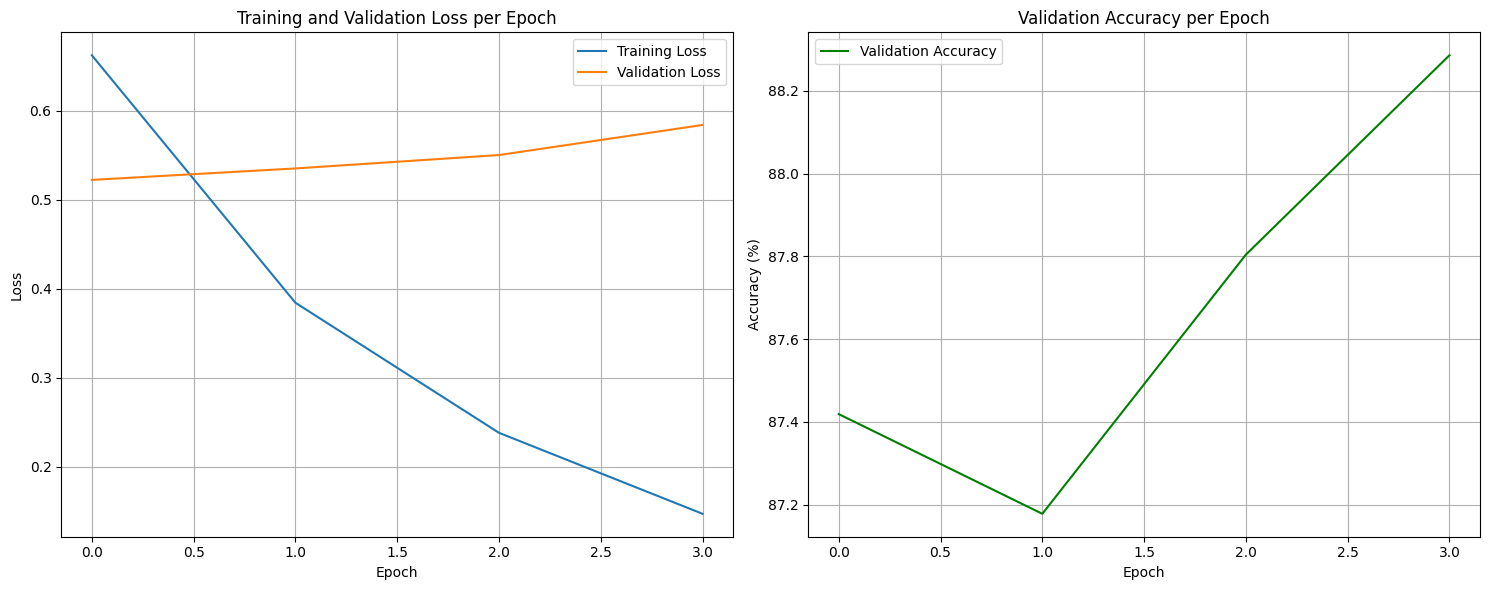

In [ ]:
import matplotlib.pyplot as plt

# Assuming the train function was called and returned 'history'
# Example: best_model, history = train(...)

if 'history' in locals() and history is not None:
    # Create a figure with two subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot Loss on the left subplot
    axes[0].plot(history['train_loss'], label='Training Loss')
    axes[0].plot(history['val_loss'], label='Validation Loss')
    axes[0].set_title('Training and Validation Loss per Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Accuracy on the right subplot
    axes[1].plot(history['val_accuracy'], label='Validation Accuracy', color='green')
    axes[1].set_title('Validation Accuracy per Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True)

    # Adjust layout to prevent titles/labels from overlapping
    plt.tight_layout()
    plt.show()
else:
    print("Training history not available. Please run the training cell first.")

# Model evaluation

## Qwen3-0.6B

In [ ]:
def get_sample_logprob(sample, model):
    model.eval()
    model.to(device)

    # Extract input_ids and attention_mask from the sample
    input_ids = sample["input_ids"].unsqueeze(0).to(device) # Add batch dimension: (1, sequence_length)
    attention_mask = sample["attention_mask"].unsqueeze(0).to(device)

    # Disable gradient calculation because the model is not used for training
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # logits shape: (batch_size, seq_len, vocab_size)
    logits = outputs.logits

    # Calculate log probabilities for each token (except first start token)
    total_log_prob = 0.0
    for i in range(1, input_ids.shape[1]):
        # Get logits for the previous position predicting the current token
        if attention_mask[0, i] == 1:
            current_logits = logits[0, i-1, :]
            current_token_id = input_ids[0, i]
            log_prob = torch.log_softmax(current_logits, dim=-1)[current_token_id].item()
            total_log_prob += log_prob

    return total_log_prob

In [ ]:
import tqdm

correct_pairs = 0
total_pairs = 0

# Iterate directly over the test_dataset which now yields paired data
for pair_data in tqdm.tqdm(test_dataset, desc="Evaluating model"):
    total_pairs += 1

    # Extract correct and ungrammatical sentence data from the paired item
    correct_sample = {
        "input_ids": pair_data["correct_input_ids"],
        "attention_mask": pair_data["correct_attention_mask"],
    }
    ungrammatical_sample = {
        "input_ids": pair_data["ungrammatical_input_ids"],
        "attention_mask": pair_data["ungrammatical_attention_mask"],
    }

    # Calculate log probabilities for the pair
    # Ensure the model is on the correct device before calling get_sample_logprob
    prob_correct = get_sample_logprob(correct_sample, model)
    prob_ungrammatical = get_sample_logprob(ungrammatical_sample, model)

    # Calculate overall correct count
    if prob_correct > prob_ungrammatical:
        correct_pairs += 1

# Calculate overall accuracy
overall_accuracy = (correct_pairs / total_pairs) * 100 if total_pairs > 0 else 0

print(f"\nFinal Test Set Accuracy (Fine-tuned Model): {overall_accuracy:.2f}% ({correct_pairs}/{total_pairs})")

Evaluating model: 100%|██████████| 4149/4149 [10:38<00:00,  6.50it/s]


Final Test Set Accuracy (Fine-tuned Model): 87.18% (3617/4149)


In [ ]:
import tqdm
import torch
import torch.nn.functional as F

# Evaluate accuracy and calculate softmax probability over the two sentence log probabilities for each length bin
print("\nEvaluating accuracy and calculating softmax probability over two sentence log probabilities for each length bin:")

new_length_group_accuracy = {}
new_length_group_metric = {} # This will store the average of the softmax probability over the two sentence log probabilities

# Sort by label for ordered output (reuse sort_key)
def sort_key(label):
    if '-' in label:
        try:
            return int(label.split('-')[0])
        except ValueError:
            pass
    elif '+' in label:
         try:
             return int(label.split('+')[0])
         except ValueError:
              pass
    return label

# Ensure the model is in evaluation mode and on the correct device
# Access the model object from the best_model tuple (it's the first element)
eval_model = best_model
eval_model.eval()
eval_model.to(device)

# Use the already calculated new_grouped_pairs (which contains the test pairs grouped by length)
for label, pairs in sorted(new_grouped_pairs.items(), key=lambda item: sort_key(item[0])):
    correct_predictions_bin = 0
    total_pairs_bin = len(pairs)
    group_metric_sum = 0.0 # Sum of softmax probabilities over two sentence log probabilities for this bin


    if total_pairs_bin == 0:
        print(f"Length bin '{label}': 0 pairs, Accuracy: N/A, Average Softmax Probability over Sentence Log Probabilities: N/A")
        continue

    # Create a dataset and dataloader for the current bin's pairs
    # GrammarCheckDataset is designed to take a list of pairs
    bin_dataset = GrammarCheckDataset(pairs, tokenizer)
    # Reduce batch size for evaluation to mitigate OutOfMemoryError
    evaluation_batch_size = 4
    bin_dataloader = DataLoader(bin_dataset, batch_size=evaluation_batch_size) # Use a smaller batch size for evaluation

    for batch in tqdm.tqdm(bin_dataloader, desc=f"Processing bin '{label}'"):
        correct_input_ids = batch["correct_input_ids"].to(device)
        correct_attention_mask = batch["correct_attention_mask"].to(device)
        ungrammatical_input_ids = batch["ungrammatical_input_ids"].to(device)
        ungrammatical_attention_mask = batch["ungrammatical_attention_mask"].to(device)


        # Forward pass for correct and ungrammatical sentences using eval_model
        with torch.no_grad():
            outputs_correct = eval_model(input_ids=correct_input_ids, attention_mask=correct_attention_mask)
            correct_logits = outputs_correct.logits

            outputs_ungrammatical = eval_model(input_ids=ungrammatical_input_ids, attention_mask=ungrammatical_attention_mask)
            ungrammatical_logits = outputs_ungrammatical.logits


        # Calculate sentence log probabilities
        # For correct sentences
        shifted_correct_logits = correct_logits[:, :-1, :].contiguous()
        correct_target_ids = correct_input_ids[:, 1:]
        correct_target_mask = correct_attention_mask[:, 1:]
        log_probs_correct_all = torch.log_softmax(shifted_correct_logits, dim=-1)
        one_hot_correct_target_ids = F.one_hot(correct_target_ids, num_classes=log_probs_correct_all.size(-1)).float()
        selected_log_probs_correct = torch.einsum('bsv,bsv->bs', log_probs_correct_all, one_hot_correct_target_ids)
        masked_log_probs_correct = selected_log_probs_correct * correct_target_mask.float()
        sentence_log_probs_correct = masked_log_probs_correct.sum(dim=-1) # (batch_size,)

        # For ungrammatical sentences
        shifted_ungrammatical_logits = ungrammatical_logits[:, :-1, :].contiguous()
        ungrammatical_target_ids = ungrammatical_input_ids[:, 1:]
        ungrammatical_target_mask = ungrammatical_attention_mask[:, 1:]
        log_probs_ungrammatical_all = torch.log_softmax(shifted_ungrammatical_logits, dim=-1)
        one_hot_ungrammatical_target_ids = F.one_hot(ungrammatical_target_ids, num_classes=log_probs_ungrammatical_all.size(-1)).float()
        selected_log_probs_ungrammatical = torch.einsum('bsv,bsv->bs', log_probs_ungrammatical_all, one_hot_ungrammatical_target_ids)
        masked_log_probs_ungrammatical = selected_log_probs_ungrammatical * ungrammatical_target_mask.float()
        sentence_log_probs_ungrammatical = masked_log_probs_ungrammatical.sum(dim=-1) # (batch_size,)

        # Compare log probabilities within each pair (for Accuracy)
        for i in range(sentence_log_probs_correct.shape[0]):
            if sentence_log_probs_correct[i] > sentence_log_probs_ungrammatical[i]:
                correct_predictions_bin += 1

        # Calculate softmax probability over the two sentence log probabilities for each pair in the batch
        # Stack log probabilities for softmax
        stacked_log_probs = torch.stack([sentence_log_probs_ungrammatical, sentence_log_probs_correct], dim=-1) # (batch_size, 2)
        softmax_probs = torch.softmax(stacked_log_probs, dim=-1) # (batch_size, 2)

        # The metric value is the softmax probability corresponding to the correct sentence (index 1)
        metric_values_batch = softmax_probs[:, 1] # (batch_size,)

        group_metric_sum += metric_values_batch.sum().item()


    # Calculate accuracy and average softmax probability metric for the current bin
    accuracy_bin = (correct_predictions_bin / total_pairs_bin) * 100 if total_pairs_bin > 0 else 0
    average_metric_bin = group_metric_sum / total_pairs_bin if total_pairs_bin > 0 else 0

    new_length_group_accuracy[label] = accuracy_bin
    new_length_group_metric[label] = average_metric_bin

    print(f"Length bin '{label}': {total_pairs_bin} pairs, Accuracy: {accuracy_bin:.2f}%, Average Softmax Probability over Sentence Log Probabilities: {average_metric_bin:.4f}")

# Print overall results by new length group
print("\nEvaluation Results by New Length Group:")
for label, accuracy in sorted(new_length_group_accuracy.items(), key=lambda item: sort_key(item[0])):
    metric = new_length_group_metric[label]
    print(f"'{label}': Accuracy={accuracy:.2f}%, Average Softmax Probability over Sentence Log Probabilities: {metric:.4f}")


Evaluating accuracy and calculating softmax probability over two sentence log probabilities for each length bin:


Processing bin '0-9': 100%|██████████| 77/77 [00:15<00:00,  4.91it/s]


Length bin '0-9': 308 pairs, Accuracy: 79.55%, Average Softmax Probability over Sentence Log Probabilities: 0.7681


Processing bin '10-19': 100%|██████████| 273/273 [00:55<00:00,  4.93it/s]


Length bin '10-19': 1091 pairs, Accuracy: 82.22%, Average Softmax Probability over Sentence Log Probabilities: 0.8031


Processing bin '20-29': 100%|██████████| 165/165 [00:33<00:00,  4.93it/s]


Length bin '20-29': 657 pairs, Accuracy: 85.69%, Average Softmax Probability over Sentence Log Probabilities: 0.8544


Processing bin '30-39': 100%|██████████| 140/140 [00:28<00:00,  4.91it/s]


Length bin '30-39': 560 pairs, Accuracy: 88.39%, Average Softmax Probability over Sentence Log Probabilities: 0.8714


Processing bin '40-49': 100%|██████████| 121/121 [00:24<00:00,  4.93it/s]


Length bin '40-49': 481 pairs, Accuracy: 90.85%, Average Softmax Probability over Sentence Log Probabilities: 0.9049


Processing bin '50-59': 100%|██████████| 86/86 [00:17<00:00,  4.93it/s]


Length bin '50-59': 341 pairs, Accuracy: 89.74%, Average Softmax Probability over Sentence Log Probabilities: 0.8921


Processing bin '60-69': 100%|██████████| 62/62 [00:12<00:00,  4.90it/s]


Length bin '60-69': 248 pairs, Accuracy: 90.73%, Average Softmax Probability over Sentence Log Probabilities: 0.9127


Processing bin '70-79': 100%|██████████| 44/44 [00:08<00:00,  4.89it/s]


Length bin '70-79': 176 pairs, Accuracy: 95.45%, Average Softmax Probability over Sentence Log Probabilities: 0.9486


Processing bin '80-89': 100%|██████████| 29/29 [00:05<00:00,  4.95it/s]


Length bin '80-89': 114 pairs, Accuracy: 97.37%, Average Softmax Probability over Sentence Log Probabilities: 0.9602


Processing bin '90-99': 100%|██████████| 15/15 [00:03<00:00,  4.96it/s]


Length bin '90-99': 59 pairs, Accuracy: 98.31%, Average Softmax Probability over Sentence Log Probabilities: 0.9799


Processing bin '100-109': 100%|██████████| 11/11 [00:02<00:00,  5.06it/s]


Length bin '100-109': 42 pairs, Accuracy: 95.24%, Average Softmax Probability over Sentence Log Probabilities: 0.9526


Processing bin '110+': 100%|██████████| 18/18 [00:03<00:00,  4.87it/s]

Length bin '110+': 72 pairs, Accuracy: 100.00%, Average Softmax Probability over Sentence Log Probabilities: 0.9989

Evaluation Results by New Length Group:
'0-9': Accuracy=79.55%, Average Softmax Probability over Sentence Log Probabilities: 0.7681
'10-19': Accuracy=82.22%, Average Softmax Probability over Sentence Log Probabilities: 0.8031
'20-29': Accuracy=85.69%, Average Softmax Probability over Sentence Log Probabilities: 0.8544
'30-39': Accuracy=88.39%, Average Softmax Probability over Sentence Log Probabilities: 0.8714
'40-49': Accuracy=90.85%, Average Softmax Probability over Sentence Log Probabilities: 0.9049
'50-59': Accuracy=89.74%, Average Softmax Probability over Sentence Log Probabilities: 0.8921
'60-69': Accuracy=90.73%, Average Softmax Probability over Sentence Log Probabilities: 0.9127
'70-79': Accuracy=95.45%, Average Softmax Probability over Sentence Log Probabilities: 0.9486
'80-89': Accuracy=97.37%, Average Softmax Probability over Sentence Log Probabilities: 0.9602